In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import importlib

import endoutbreakvbd
import endoutbreakvbd.chikungunya
import endoutbreakvbd.eop
import endoutbreakvbd.inference
import endoutbreakvbd.model
import endoutbreakvbd.utils

importlib.reload(endoutbreakvbd)
importlib.reload(endoutbreakvbd.chikungunya)
importlib.reload(endoutbreakvbd.eop)
importlib.reload(endoutbreakvbd.inference)
importlib.reload(endoutbreakvbd.model)
importlib.reload(endoutbreakvbd.utils)

from endoutbreakvbd import renewal_model
from endoutbreakvbd.chikungunya import get_parameters, get_suitability_data
from endoutbreakvbd.inference import fit_suitability_model
from endoutbreakvbd.utils import month_start_xticks

In [3]:
parameters = get_parameters()
gen_time_dist_vec = parameters["gen_time_dist_vec"]
df_suitability = get_suitability_data()

rng = np.random.default_rng(2)

In [4]:
suitability_vec_all = df_suitability["suitability_smoothed"].to_numpy()
doy_vec_all = np.arange(1, 366)

rep_no_factor = 2.5
rep_no_vec_all = rep_no_factor * suitability_vec_all


def rep_no_func_doy(doy):
    return np.interp(doy, doy_vec_all, rep_no_vec_all, period=365)

Found outbreak after 373 tries.


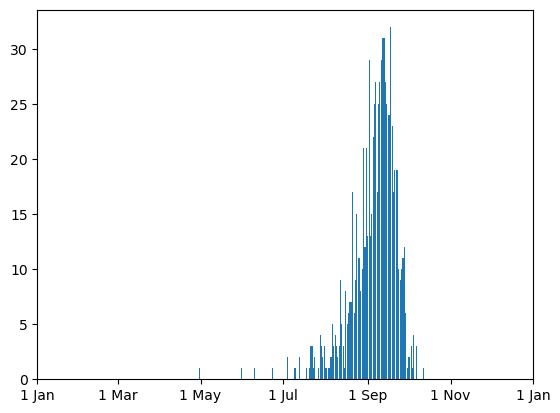

In [5]:
doy_start = 120

found_outbreak = False
tries = 0
while not found_outbreak:
    incidence_vec = renewal_model(
        rep_no_func=lambda t: rep_no_func_doy(doy_start + t),
        t_stop=366,
        gen_time_dist_vec=gen_time_dist_vec,
        rng=rng,
        incidence_init=1,
    )
    if incidence_vec.sum() >= 500:
        print(f"Found outbreak after {tries} tries.")
        found_outbreak = True
    tries += 1
    if tries > 10000:
        raise RuntimeError("Could not simulate outbreak with at least 500 cases.")

fig, ax = plt.subplots()
ax.bar(doy_start + np.arange(len(incidence_vec)), incidence_vec)
ax.set_xlim(1, 366)
month_start_xticks(ax)

In [6]:
doy_vec = np.arange(doy_start, doy_start + len(incidence_vec))
suitability_vec = suitability_vec_all[doy_vec - 1]
rep_no_vec = rep_no_vec_all[doy_vec - 1]

idata = fit_suitability_model(
    incidence_vec=incidence_vec,
    gen_time_dist_vec=gen_time_dist_vec,
    suitability_mean_vec=suitability_vec,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_rep_no_factor_vec, suitability_ext]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


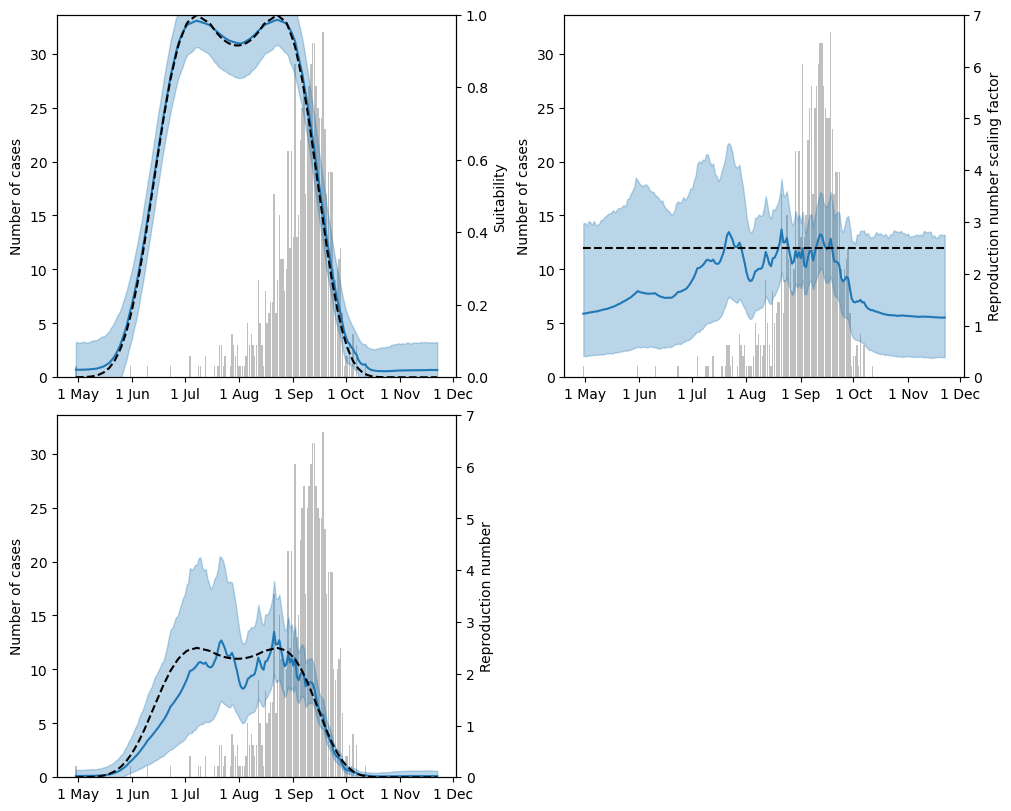

In [7]:
def plot_data_and_twin(ax):
    ax.bar(doy_vec, incidence_vec, color="gray", alpha=0.5)
    # ax.set_ylim(0, 16)
    ax.set_ylabel("Number of cases")
    twin_ax = ax.twinx()
    return twin_ax


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(10, 8), constrained_layout=True
)
axs = [ax1, ax2, ax3]
fig.delaxes(ax4)
twin_axs = [plot_data_and_twin(ax) for ax in axs]
twin_axs[0].plot(
    doy_vec,
    idata.posterior["suitability_vec"].mean(dim=["chain", "draw"]),
    color="tab:blue",
)
twin_axs[0].fill_between(
    doy_vec,
    np.percentile(idata.posterior["suitability_vec"].values, 2.5, axis=(0, 1)),
    np.percentile(idata.posterior["suitability_vec"].values, 97.5, axis=(0, 1)),
    color="tab:blue",
    alpha=0.3,
)
twin_axs[0].plot(
    doy_vec,
    suitability_vec,
    color="black",
    linestyle="dashed",
)
twin_axs[1].plot(
    doy_vec,
    idata.posterior["rep_no_factor_vec"].mean(dim=["chain", "draw"]),
    color="tab:blue",
)
twin_axs[1].fill_between(
    doy_vec,
    np.percentile(idata.posterior["rep_no_factor_vec"].values, 2.5, axis=(0, 1)),
    np.percentile(idata.posterior["rep_no_factor_vec"].values, 97.5, axis=(0, 1)),
    color="tab:blue",
    alpha=0.3,
)
twin_axs[1].plot(
    doy_vec, rep_no_factor * np.ones(doy_vec.size), color="black", linestyle="dashed"
)
twin_axs[2].plot(
    doy_vec,
    idata.posterior["rep_no_vec"].mean(dim=["chain", "draw"]),
    color="tab:blue",
)
twin_axs[2].fill_between(
    doy_vec,
    np.percentile(idata.posterior["rep_no_vec"].values, 2.5, axis=(0, 1)),
    np.percentile(idata.posterior["rep_no_vec"].values, 97.5, axis=(0, 1)),
    color="tab:blue",
    alpha=0.3,
)
twin_axs[2].plot(doy_vec, rep_no_vec, color="black", linestyle="dashed")
month_start_xticks(axs[0], interval_months=1)
twin_axs[0].set_ylim(0, 1)
twin_axs[0].set_ylabel("Suitability")
month_start_xticks(axs[1], interval_months=1)
twin_axs[1].set_ylim(0, 7)
twin_axs[1].set_ylabel("Reproduction number scaling factor")
month_start_xticks(axs[2], interval_months=1)
twin_axs[2].set_ylim(0, 7)
twin_axs[2].set_ylabel("Reproduction number");